# Estimating average treatment effects

In this notebook we will see how to estimate the ATE under the assumption of unconfoundedness using regression. 

There are many estimators for the ATE. Here we will take a simple approach, and use linear regression plus the plug-in principle to obtain a point estimate of the ATE.

We then will use the nonparametric bootstrap to construct (approximately valid) confidence intervals.

## The model

To illustrate, consider the following *structural* model:

$$
\begin{align}
X_i &\leftarrow  I(U_x >0)\\
D_i &\leftarrow I( \gamma_0 + \gamma_1 X_i  + U_d > 0) \\ 
Y_i &\leftarrow \beta_0 + \beta_1 D_i + \beta_2 X_i + \beta_3 D_i X_i + U_d \\ 
\end{align}
$$

Where $I(\cdot)$ is the indicator function, and the $U$'s are mutually independent disturbances.

Our goal is to identify the ATE:

$$
ATE = E[Y(1)] - E[Y(0)].
$$

In this model, the ATE evaluates to:


$$
\begin{align}
ATE 
&= E[ \beta_0 + \beta_1 (1) + \beta_2 X_i + \beta_3 (1) X_i + U_d] - E[ \beta_0 + \beta_1 (0) + \beta_2 X_i + \beta_3 (0) X_i + U_d]\\
&= \beta_1 +  \beta_3 E[X_i] 
\end{align}
$$

This structural model has the following associated causal diagram:

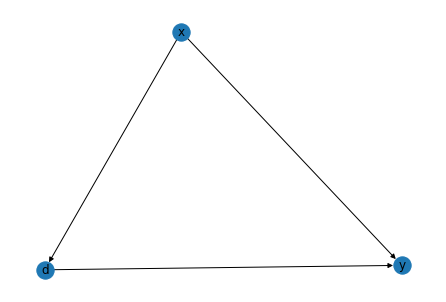

In [14]:
import networkx as nx
graph = nx.DiGraph()
graph.add_edges_from([("x", "d"), ("x", "y"), ("d", "y")])
nx.draw(graph,with_labels=True, arrows=True)

We see that $X$ satisfies the backdoor criterion for identifying the effect of $X$ on $Y$, and thus conditional ignorability holds:

$$
Y_i(d) \perp\!\!\!\perp D_i \mid X_i
$$

A well known result in causal inference is that the ATE can then be idenfied via the adjustment formula:

$$
ATE = E[E[Y_i|D_i=1, X_i] - E[Y_i|D_i=0, X_i] ]
$$

Our goal is to obtain a point estimate and a confidence interval for the ATE.

# Estimation and inference

Here we will simply use the sample analog of the above equation. First, we fit a regression model to estimate the CEF. Then we take the empirical expectation over $X_i$. Our estimator is:

$$
\widehat{ATE}=\frac{1}{n}\sum_i[\hat{E}[Y_i|D_i=1,X_i]-\hat{E}[Y_i|D_i=0,X_i]]
$$

Where $\hat{E}[Y_i|D_i,X_i]$ is our estimated regression. Let's to do this in R.

First, let us simulate some data.

In [8]:
# simulate sample of size 1,000
import numpy as np
np.random.seed(5)
n = 1000
x = (np.random.normal(0,1,n) > 0)*1
d = (x + np.random.normal(0,1,n) > 0 )*1
y = 1 + 1*d + 3*x - 4*d*x + np.random.normal(0,1,n)

With the above parameters, we know the true ATE is:

$$
\begin{align}
ATE 
&= 1 -  4 \times 0.5 = 1-2 = -1
\end{align}
$$

Our plug-in estimate is:

In [9]:
import statsmodels.formula.api as smf
# ATE estimate
data = {"x":x, "y":y,"d":d}
# fit regression
ols=smf.ols(formula = 'y ~ d+x+d:x', data = data).fit()
Ey1 = np.mean(ols.predict({"x":x, "d":np.ones(len(x))}))
Ey0 = np.mean(ols.predict({"x":x, "d":np.zeros(len(x))}))
ATE = Ey1 - Ey0
ATE

-1.0311935104667695

Which is close to the truth. 

Now we will construct a 95% confidence intervals using the nonparametric bootstrap (10,000 bootstrap samples).

In [11]:
# signficance level
alpha = 0.05

ATE=np.zeros(10000)
# bootstrap CI
for i in range(10000):
    # sample rows
    idx=np.random.choice(np.arange(n), size=n, replace=True)
    
    # fit OLS to boostrapped cases
    x_boot   = x[idx]
    y_boot   = y[idx]
    d_boot   = d[idx]
    data = {"x":x_boot, "y":y_boot,"d":d_boot}
    # fit regression
    ols=smf.ols(formula = 'y ~ d+x+d:x', data = data).fit()
    Ey1 = np.mean(ols.predict({"x":x, "d":np.ones(len(x))}))
    Ey0 = np.mean(ols.predict({"x":x, "d":np.zeros(len(x))}))
    ATE[i] = Ey1 - Ey0

# CI for ATE
print("Percentile CI for ATE:",np.quantile(ATE,[alpha/2,1-alpha/2]))

Percentile CI for ATE: [-1.17770974 -0.88000477]
